In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

np.random.seed(42)

print("Generating and splitting dataset...")

# Generate 5000 synthetic data points with 5 clusters
n_samples = 5000
n_features = 2
n_classes = 5

# Create synthetic data
x, y_labels = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_classes,
    cluster_std=1.5,
    random_state=42
)

# Convert labels to one-hot encoding
y = np.zeros((len(y_labels), n_classes))
for i in range(len(y_labels)):
    y[i, y_labels[i]] = 1

# Split into 80% training and 20% testing
x_train, x_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(
    x, y, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

print(f"Training set size: {x_train.shape[0]} samples")
print(f"Testing set size: {x_test.shape[0]} samples")
print(f"Features per sample: {x_train.shape[1]}")
print(f"Number of classes: {n_classes}")

Generating and splitting dataset...
Training set size: 4000 samples
Testing set size: 1000 samples
Features per sample: 2
Number of classes: 5


In [21]:
class NeuralNetwork(object):
    def __init__(self):
        inputLayerNeurons = 2
        hiddenLayer_1 = 10
        hiddenLayer_2 = 15
        hiddenLayer_3 = 10
        outputLayerNeurons = 5

        self.learning_rate = 0.1

        # Initialize weights
        self.W_H1_I = np.random.randn(inputLayerNeurons, hiddenLayer_1) * 0.1
        self.W_H2_H1 = np.random.randn(hiddenLayer_1, hiddenLayer_2) * 0.1
        self.W_H3_H2 = np.random.randn(hiddenLayer_2, hiddenLayer_3) * 0.1
        self.W_O_H3 = np.random.randn(hiddenLayer_3, outputLayerNeurons) * 0.1

        # Initialize biases (added for better performance)
        self.b_H1 = np.zeros((1, hiddenLayer_1))
        self.b_H2 = np.zeros((1, hiddenLayer_2))
        self.b_H3 = np.zeros((1, hiddenLayer_3))
        self.b_O = np.zeros((1, outputLayerNeurons))

    def sigmoid(self, x, der=False):
        if der == True:
            return x * (1 - x)
        else:
            return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feedForward(self, x):
        # Hidden layer 1
        hiden1_input = np.dot(x, self.W_H1_I) + self.b_H1
        self.hidden1_output = self.sigmoid(hiden1_input)

        # Hidden layer 2
        hiden2_input = np.dot(self.hidden1_output, self.W_H2_H1) + self.b_H2
        self.hidden2_output = self.sigmoid(hiden2_input)

        # Hidden layer 3
        hiden3_input = np.dot(self.hidden2_output, self.W_H3_H2) + self.b_H3
        self.hidden3_output = self.sigmoid(hiden3_input)

        # Output layer (using softmax for multi-class)
        output_input = np.dot(self.hidden3_output, self.W_O_H3) + self.b_O
        pred = self.softmax(output_input)

        return pred

    def backPropagation(self, x, y, pred):
        m = x.shape[0]

        # Output layer error (for softmax + cross-entropy)
        output_error = pred - y
        output_delta = output_error / m  # Simplified for softmax

        # Hidden layer 3 error
        hidden3_error = output_delta.dot(self.W_O_H3.T)
        hidden3_delta = hidden3_error * self.sigmoid(self.hidden3_output, der=True)

        # Hidden layer 2 error
        hidden2_error = hidden3_delta.dot(self.W_H3_H2.T)
        hidden2_delta = hidden2_error * self.sigmoid(self.hidden2_output, der=True)

        # Hidden layer 1 error
        hidden1_error = hidden2_delta.dot(self.W_H2_H1.T)
        hidden1_delta = hidden1_error * self.sigmoid(self.hidden1_output, der=True)

        # Update weights and biases
        self.W_O_H3 -= self.learning_rate * self.hidden3_output.T.dot(output_delta)
        self.b_O -= self.learning_rate * np.sum(output_delta, axis=0, keepdims=True)

        self.W_H3_H2 -= self.learning_rate * self.hidden2_output.T.dot(hidden3_delta)
        self.b_H3 -= self.learning_rate * np.sum(hidden3_delta, axis=0, keepdims=True)

        self.W_H2_H1 -= self.learning_rate * self.hidden1_output.T.dot(hidden2_delta)
        self.b_H2 -= self.learning_rate * np.sum(hidden2_delta, axis=0, keepdims=True)

        self.W_H1_I -= self.learning_rate * x.T.dot(hidden1_delta)
        self.b_H1 -= self.learning_rate * np.sum(hidden1_delta, axis=0, keepdims=True)

    def train(self, x, y, epochs=5000):
        self.errors = []
        for i in range(epochs):
            output = self.feedForward(x)
            self.backPropagation(x, y, output)

            # Calculate loss (cross-entropy)
            loss = -np.mean(np.sum(y * np.log(output + 1e-8), axis=1))
            self.errors.append(loss)

            if i % 1000 == 0:
                print(f"Epoch {i}: Loss = {loss:.4f}")

    def predict(self, x):
        output = self.feedForward(x)
        return np.argmax(output, axis=1)

Training the neural network...
Epoch 0: Loss = 1.6135
Epoch 1000: Loss = 1.6085
Epoch 2000: Loss = 1.5501
Epoch 3000: Loss = 0.7744
Epoch 4000: Loss = 0.5297


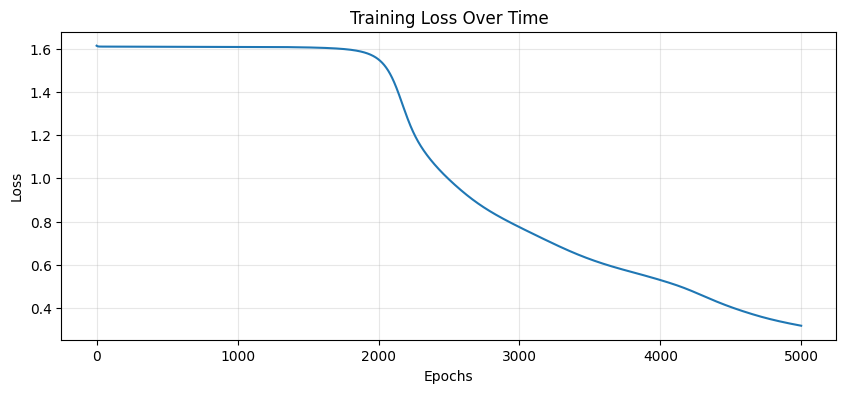

In [22]:
print("Training the neural network...")
NN = NeuralNetwork()
NN.train(x_train, y_train, epochs=5000)

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(NN.errors)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True, alpha=0.3)
plt.show()

In [23]:
# Make predictions on test set
y_test_pred = NN.predict(x_test)
y_test_true = np.argmax(y_test, axis=1)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9410


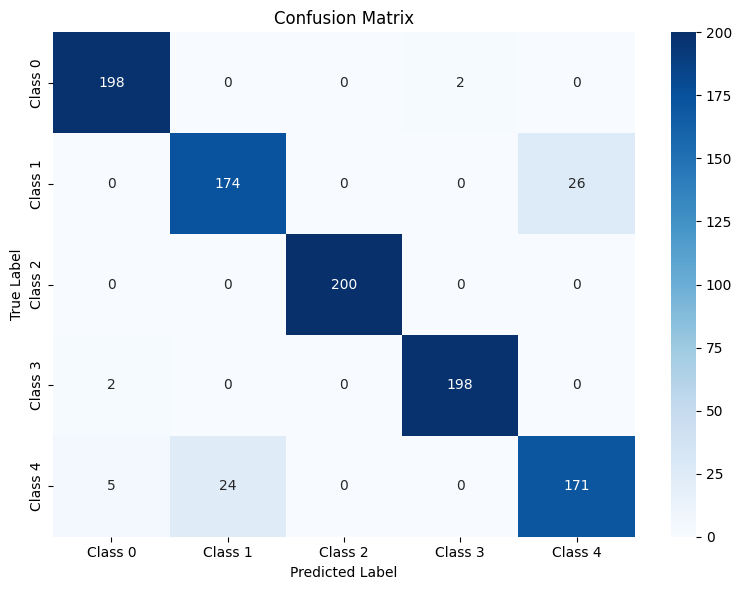

In [24]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_true, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Class {i}' for i in range(n_classes)],
            yticklabels=[f'Class {i}' for i in range(n_classes)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [25]:
# Generate classification report
print("\n" + "-"*50)
print("Classification Report:")
print("-"*50)
class_report = classification_report(y_test_true, y_test_pred, target_names=[f'Class {i}' for i in range(n_classes)])
print(class_report)


--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

     Class 0       0.97      0.99      0.98       200
     Class 1       0.88      0.87      0.87       200
     Class 2       1.00      1.00      1.00       200
     Class 3       0.99      0.99      0.99       200
     Class 4       0.87      0.85      0.86       200

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000

